In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [2]:
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
gpu_id = 2;
from torch.cuda import set_device
set_device(gpu_id)
from tqdm import tnrange

/home/koshelev/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [39]:
class Synthesis():
    def __init__(self, init_std=0.3):
        self.init_std = init_std;
        
    def sample(self, module, num_iter=10, learning_rate=1e-2, add_noise=True):
        assert isinstance(module.X, torch.nn.Parameter), 'Expected X to be an instance of torch.nn.Parameter';
        
        model.train(False);
        
        # we do not want to create a graph and do backprop on net parameters, since we need only gradient of X
        for name, param in module.named_parameters():
            if name != 'X':
                param.requires_grad = False;
            else:
                param.requires_grad = True;
        
        module.X.data = module.X.data.normal_(mean=0, std=self.init_std);
        #module.X.data = module.X.data.fill_(0);
        #opt = torch.optim.SGD([module.X], lr=learning_rate);
        opt = torch.optim.Adam([module.X], lr=learning_rate, amsgrad=True);
        
        for i in range(num_iter):
            opt.zero_grad();
            classes = -module.to_synth();
            for j in range(classes.shape[0]):
                classes[j, j, ...].backward(retain_graph=True);
                
            if add_noise:
                module.X.data += torch.empty_like(module.X.data).normal_(mean=0, std=(2*opt.param_groups[0]['lr'])**0.5);
            
            opt.step()
        
        model.train(True);
        
        for name, param in module.named_parameters():
            if name != 'X':
                param.requires_grad = True;
            else:
                param.requires_grad = False;
        
        return module.X.data;

In [138]:
class MnistDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir='data/', training=True):
        self.imgs = [];
        self.labels = [];
        self.fake = [];
        
        if training:
            x, y = torch.load(root_dir + 'processed/training.pt');
        else:
            x, y = torch.load(root_dir + 'processed/test.pt');
        for i in range(y.shape[0]):
            self.imgs.append(x[i, ...].float()/255);
            self.labels.append(y[i].long());
            self.fake.append(torch.ByteTensor([0])[0]);
    
    def __len__(self):
        return len(self.labels);

    def __getitem__(self, idx):
        
        x = self.imgs[idx];
        y = self.labels[idx];
        fake = self.fake[idx];
        
        return x.unsqueeze(0), y.float().unsqueeze(0), fake;
    
    def add_artificial(self, X):
        for i in range(X.shape[0]):
            self.imgs.append(X[i, 0, ...].detach().cpu());
            self.labels.append(self.labels[0].new(1).fill_(-i)[0]);
            self.fake.append(torch.ByteTensor([1])[0])
        pass;

In [5]:
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.X = torch.nn.Parameter(torch.empty((10, 1, 224, 224)).normal_(mean=0, std=0.3));
        self.X.requires_grad = False;
        
    def forward(self, x):
        return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)
    
    def to_synth(self):
        return self.net.forward(self.X);

def get_data_loaders(train_batch_size, val_batch_size):
    mnist = MNIST(download=False, train=True, root=".").train_data.float()
    
    data_transform = Compose([ Resize((224, 224)),ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])

    train_loader = DataLoader(MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(MNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

In [6]:
from collections import OrderedDict
class MnistResNet(torch.nn.Module):
    def __init__(self):
        super(MnistResNet, self).__init__()
        
        self.net = nn.Sequential(OrderedDict([
            ('conv1', torch.nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)),
            ('bn1', torch.nn.BatchNorm2d(64)),
            ('relu1', torch.nn.ReLU()),
            
            ('conv2', torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)),
            ('bn2', torch.nn.BatchNorm2d(128)),
            ('relu2', torch.nn.ReLU()),
            
            ('conv3', torch.nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)),
            ('bn3', torch.nn.BatchNorm2d(256)),
            ('relu3', torch.nn.ReLU()),
            
            ('conv4', torch.nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
            ('bn4', torch.nn.BatchNorm2d(512)),
            ('relu4', torch.nn.ReLU()),
            
            ('conv5', torch.nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)),
            ('bn5', torch.nn.BatchNorm2d(256)),
            ('relu5', torch.nn.ReLU()),
            
            ('conv6', torch.nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
            ('bn6', torch.nn.BatchNorm2d(512)),
            ('relu6', torch.nn.ReLU()),
            
            ('conv7', torch.nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
            ('bn7', torch.nn.BatchNorm2d(256)),
            ('relu7', torch.nn.ReLU()),
            
            ('conv8', torch.nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)),
            ('bn8', torch.nn.BatchNorm2d(512)),
            ('relu8', torch.nn.ReLU()),
        
            ('conv9', torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)),
            ('bn9', torch.nn.BatchNorm2d(512)),
            ('relu9', torch.nn.ReLU())]));
        
        self.fc = torch.nn.Linear(512, 10);
        
        self.X = torch.nn.Parameter(torch.empty((10, 1, 28, 28)).normal_(mean=0, std=0.3));
        self.X.requires_grad = False;
        
    def forward(self, x):
        return torch.sigmoid(self.fc(self.net(x).squeeze(-1).squeeze(-1)));
    
    def to_synth(self):
        return self.fc(self.net(self.X).squeeze(-1).squeeze(-1));
    
def get_data_loaders(train_batch_size, val_batch_size):
    mnist = MNIST(download=False, train=True, root=".").train_data.float()
    
    data_transform = Compose([ Resize((224, 224)),ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])

    train_loader = DataLoader(MnistDataset(root_dir=''),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(MnistDataset(root_dir='', training=False),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

In [7]:
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [113]:
def train(model, train_loader, val_loader, epochs=1, alpha=0.1):

    start_ts = time.time()

    losses = []
    loss_function = nn.CrossEntropyLoss()
    #optimizer = optim.Adadelta(model.parameters())
    optimizer = optim.Adam(model.parameters(), amsgrad=True)

    batches = len(train_loader)
    val_batches = len(val_loader)

    # training loop + eval loop
    for epoch in range(epochs):
        total_loss = 0
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
        model.train()

        for i, data in progress:
            X, y, fakes = data[0].cuda(), data[1].cuda().squeeze(-1).long(), data[2].cuda()
            
            mask = torch.zeros((y.shape[0], 10)).byte();
            for i in range(y.shape[0]):
                mask[i, y[i]] = 1;
            
            model.zero_grad()
            outputs = model(X)
            loss = (1-alpha)*loss_function(outputs[1-fakes], y[1-fakes]);
            if not torch.all(fakes == 0):
                #loss += torch.sum(alpha*torch.log1p(outputs[mask][fakes]));
                y = outputs[mask][fakes];
                loss += torch.sum(alpha*torch.log1p(torch.log(y/(1-y))));
            loss.backward()
            optimizer.step()
            progress.set_description("Loss: {:.4f}".format(loss.item()))

        torch.cuda.empty_cache()

        val_losses = 0
        precision, recall, f1, accuracy = [], [], [], []

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].cuda(), data[1].cuda().squeeze(-1)
                outputs = model(X)
                val_losses += loss_function(outputs, y.long())

                predicted_classes = torch.max(outputs, 1)[1]

                for acc, metric in zip((precision, recall, f1, accuracy), 
                                       (precision_score, recall_score, f1_score, accuracy_score)):
                    acc.append(
                        calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                    )


        print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
        print_scores(precision, recall, f1, accuracy, val_batches)
        losses.append(total_loss/batches)
    pass

In [9]:
l = 1000;
tmax = 100;
train_loader, val_loader = get_data_loaders(256, 256);
for t in range(tmax):
    model = MnistResNet().cuda();
    train(model, train_loader, val_loader);
    
    s = Synthesis(init_std=0.3)
    for i in range(l):
        train_loader.dataset.add_artificial(s.sample(model, num_iter=50, learning_rate=1e-1, add_noise=True));

/home/koshelev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/koshelev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/1, training loss: 0.0, validation loss: 1.4951860904693604
	     precision: 0.9636
	        recall: 0.9627
	            F1: 0.9607
	      accuracy: 0.9631



Epoch 1/1, training loss: 0.0, validation loss: 1.4803828001022339
	     precision: 0.9865
	        recall: 0.9864
	            F1: 0.9860
	      accuracy: 0.9861



Epoch 1/1, training loss: 0.0, validation loss: 1.4795548915863037
	     precision: 0.9869
	        recall: 0.9868
	            F1: 0.9864
	      accuracy: 0.9866



Epoch 1/1, training loss: 0.0, validation loss: 1.4819211959838867
	     precision: 0.9851
	        recall: 0.9849
	            F1: 0.9846
	      accuracy: 0.9849



Epoch 1/1, training loss: 0.0, validation loss: 1.4891504049301147
	     precision: 0.9788
	        recall: 0.9775
	            F1: 0.9772
	      accuracy: 0.9777



Epoch 1/1, training loss: 0.0, validation loss: 1.4768258333206177
	     precision: 0.9872
	        recall: 0.9873
	            F1: 0.9869
	      accuracy: 0.9872



Epoch 1/1, training loss: 0.0, validation loss: 1.4814772605895996
	     precision: 0.9838
	        recall: 0.9834
	            F1: 0.9830
	      accuracy: 0.9835



Epoch 1/1, training loss: 0.0, validation loss: 1.4825327396392822
	     precision: 0.9822
	        recall: 0.9812
	            F1: 0.9811
	      accuracy: 0.9812



Epoch 1/1, training loss: 0.0, validation loss: 1.4762018918991089
	     precision: 0.9882
	        recall: 0.9880
	            F1: 0.9877
	      accuracy: 0.9881



Epoch 1/1, training loss: 0.0, validation loss: 1.4819960594177246
	     precision: 0.9834
	        recall: 0.9829
	            F1: 0.9826
	      accuracy: 0.9825



Epoch 1/1, training loss: 0.0, validation loss: 1.4748495817184448
	     precision: 0.9890
	        recall: 0.9887
	            F1: 0.9885
	      accuracy: 0.9888



Epoch 1/1, training loss: 0.0, validation loss: 1.4758129119873047
	     precision: 0.9869
	        recall: 0.9871
	            F1: 0.9867
	      accuracy: 0.9868



Epoch 1/1, training loss: 0.0, validation loss: 1.4766649007797241
	     precision: 0.9843
	        recall: 0.9836
	            F1: 0.9835
	      accuracy: 0.9840



Epoch 1/1, training loss: 0.0, validation loss: 1.4735344648361206
	     precision: 0.9896
	        recall: 0.9895
	            F1: 0.9892
	      accuracy: 0.9894



Epoch 1/1, training loss: 0.0, validation loss: 1.4767462015151978
	     precision: 0.9869
	        recall: 0.9864
	            F1: 0.9862
	      accuracy: 0.9862



Epoch 1/1, training loss: 0.0, validation loss: 1.4745067358016968
	     precision: 0.9873
	        recall: 0.9878
	            F1: 0.9872
	      accuracy: 0.9875



Epoch 1/1, training loss: 0.0, validation loss: 1.477731704711914
	     precision: 0.9847
	        recall: 0.9846
	            F1: 0.9842
	      accuracy: 0.9844



Epoch 1/1, training loss: 0.0, validation loss: 1.4742461442947388
	     precision: 0.9879
	        recall: 0.9879
	            F1: 0.9876
	      accuracy: 0.9878



Epoch 1/1, training loss: 0.0, validation loss: 1.4711793661117554
	     precision: 0.9890
	        recall: 0.9893
	            F1: 0.9888
	      accuracy: 0.9892



Epoch 1/1, training loss: 0.0, validation loss: 1.4771581888198853
	     precision: 0.9833
	        recall: 0.9830
	            F1: 0.9826
	      accuracy: 0.9829



Epoch 1/1, training loss: 0.0, validation loss: 1.472130537033081
	     precision: 0.9880
	        recall: 0.9887
	            F1: 0.9881
	      accuracy: 0.9885



Epoch 1/1, training loss: 0.0, validation loss: 1.4756187200546265
	     precision: 0.9867
	        recall: 0.9868
	            F1: 0.9863
	      accuracy: 0.9864



Epoch 1/1, training loss: 0.0, validation loss: 1.473050594329834
	     precision: 0.9880
	        recall: 0.9882
	            F1: 0.9878
	      accuracy: 0.9882



Epoch 1/1, training loss: 0.0, validation loss: 1.4744089841842651
	     precision: 0.9855
	        recall: 0.9859
	            F1: 0.9853
	      accuracy: 0.9856



Epoch 1/1, training loss: 0.0, validation loss: 1.4811066389083862
	     precision: 0.9795
	        recall: 0.9789
	            F1: 0.9781
	      accuracy: 0.9787



Epoch 1/1, training loss: 0.0, validation loss: 1.4718631505966187
	     precision: 0.9886
	        recall: 0.9887
	            F1: 0.9883
	      accuracy: 0.9885



Epoch 1/1, training loss: 0.0, validation loss: 1.471610426902771
	     precision: 0.9888
	        recall: 0.9886
	            F1: 0.9884
	      accuracy: 0.9886



Epoch 1/1, training loss: 0.0, validation loss: 1.4731961488723755
	     precision: 0.9876
	        recall: 0.9873
	            F1: 0.9871
	      accuracy: 0.9875



Epoch 1/1, training loss: 0.0, validation loss: 1.479650855064392
	     precision: 0.9814
	        recall: 0.9807
	            F1: 0.9805
	      accuracy: 0.9806



Epoch 1/1, training loss: 0.0, validation loss: 1.4743465185165405
	     precision: 0.9859
	        recall: 0.9856
	            F1: 0.9853
	      accuracy: 0.9856



Epoch 1/1, training loss: 0.0, validation loss: 1.4735136032104492
	     precision: 0.9863
	        recall: 0.9858
	            F1: 0.9856
	      accuracy: 0.9859



Epoch 1/1, training loss: 0.0, validation loss: 1.4752713441848755
	     precision: 0.9838
	        recall: 0.9837
	            F1: 0.9833
	      accuracy: 0.9837



Epoch 1/1, training loss: 0.0, validation loss: 1.473111629486084
	     precision: 0.9868
	        recall: 0.9867
	            F1: 0.9863
	      accuracy: 0.9866



Epoch 1/1, training loss: 0.0, validation loss: 1.471514105796814
	     precision: 0.9878
	        recall: 0.9876
	            F1: 0.9874
	      accuracy: 0.9876



Epoch 1/1, training loss: 0.0, validation loss: 1.4719641208648682
	     precision: 0.9885
	        recall: 0.9888
	            F1: 0.9883
	      accuracy: 0.9885



Epoch 1/1, training loss: 0.0, validation loss: 1.4795106649398804
	     precision: 0.9795
	        recall: 0.9799
	            F1: 0.9788
	      accuracy: 0.9789



Epoch 1/1, training loss: 0.0, validation loss: 1.4711805582046509
	     precision: 0.9894
	        recall: 0.9897
	            F1: 0.9894
	      accuracy: 0.9896



Epoch 1/1, training loss: 0.0, validation loss: 1.4760183095932007
	     precision: 0.9859
	        recall: 0.9859
	            F1: 0.9855
	      accuracy: 0.9857



Epoch 1/1, training loss: 0.0, validation loss: 1.4727060794830322
	     precision: 0.9869
	        recall: 0.9868
	            F1: 0.9864
	      accuracy: 0.9868



Epoch 1/1, training loss: 0.0, validation loss: 1.4714961051940918
	     precision: 0.9882
	        recall: 0.9884
	            F1: 0.9880
	      accuracy: 0.9882



Epoch 1/1, training loss: 0.0, validation loss: 1.47080397605896
	     precision: 0.9903
	        recall: 0.9908
	            F1: 0.9903
	      accuracy: 0.9906



Epoch 1/1, training loss: 0.0, validation loss: 1.4726786613464355
	     precision: 0.9865
	        recall: 0.9868
	            F1: 0.9863
	      accuracy: 0.9865



Epoch 1/1, training loss: 0.0, validation loss: 1.4740185737609863
	     precision: 0.9857
	        recall: 0.9859
	            F1: 0.9853
	      accuracy: 0.9857



Epoch 1/1, training loss: 0.0, validation loss: 1.4737547636032104
	     precision: 0.9862
	        recall: 0.9864
	            F1: 0.9858
	      accuracy: 0.9858



Epoch 1/1, training loss: 0.0, validation loss: 1.470354676246643
	     precision: 0.9898
	        recall: 0.9900
	            F1: 0.9897
	      accuracy: 0.9898



Epoch 1/1, training loss: 0.0, validation loss: 1.4706412553787231
	     precision: 0.9899
	        recall: 0.9905
	            F1: 0.9899
	      accuracy: 0.9901



Epoch 1/1, training loss: 0.0, validation loss: 1.4727405309677124
	     precision: 0.9859
	        recall: 0.9864
	            F1: 0.9858
	      accuracy: 0.9862



Epoch 1/1, training loss: 0.0, validation loss: 1.4739110469818115
	     precision: 0.9858
	        recall: 0.9853
	            F1: 0.9852
	      accuracy: 0.9857



Epoch 1/1, training loss: 0.0, validation loss: 1.474223017692566
	     precision: 0.9853
	        recall: 0.9848
	            F1: 0.9846
	      accuracy: 0.9849


KeyboardInterrupt: 

In [139]:
class Synthesis():
    def __init__(self, init_std=0.3):
        self.init_std = init_std;
        
    def sample(self, module, num_iter=10, learning_rate=1e-2, add_noise=True):
        assert isinstance(module.X, torch.nn.Parameter), 'Expected X to be an instance of torch.nn.Parameter';
        
        model.train(False);
        
        # we do not want to create a graph and do backprop on net parameters, since we need only gradient of X
        for name, param in module.named_parameters():
            if name != 'X':
                param.requires_grad = False;
            else:
                param.requires_grad = True;
        
        module.X.data = module.X.data.normal_(mean=0, std=self.init_std);
        #module.X.data = module.X.data.fill_(0);
        #opt = torch.optim.SGD([module.X], lr=learning_rate);
        opt = torch.optim.Adam([module.X], lr=learning_rate, amsgrad=True);
        std_noise = learning_rate;
        
        for i in range(num_iter):
            opt.zero_grad();
            classes = -module.to_synth();
            for j in range(classes.shape[0]):
                classes[j, j, ...].backward(retain_graph=True);
                
            if add_noise:
                module.X.data += torch.empty_like(module.X.data).normal_(mean=0, std=std_noise);
                std_noise *= 0.9; 
            opt.step()
#            opt.param_groups[0]['lr'] *= 0.95;
        model.train(True);
        
        for name, param in module.named_parameters():
            if name != 'X':
                param.requires_grad = True;
            else:
                param.requires_grad = False;
        
        return module.X.data;

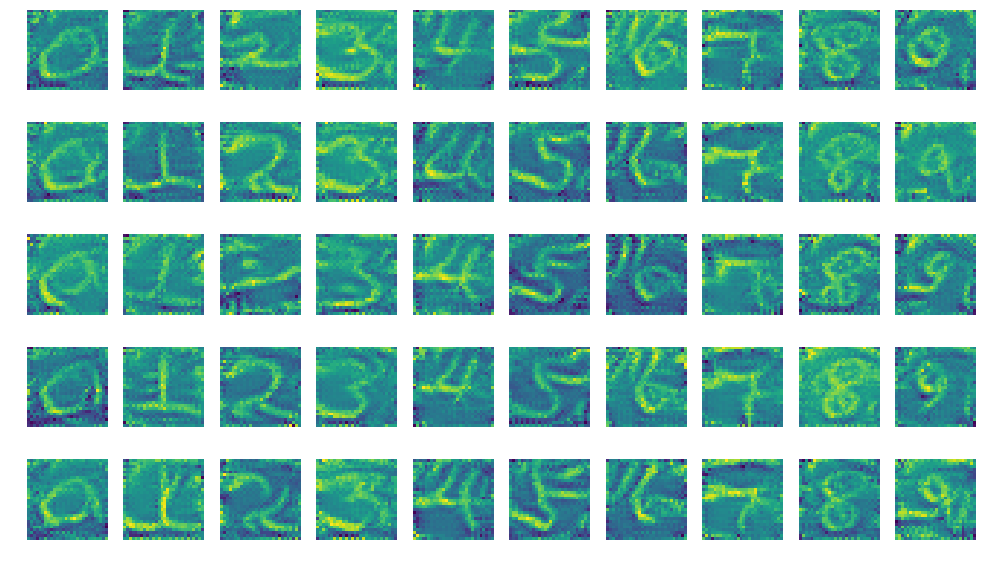

In [137]:
fig,ax = plt.subplots(nrows=5, ncols=10, figsize=(17,10));
for j in range(5):
    s = Synthesis(init_std=0.3)
    aug = s.sample(model, num_iter=50, learning_rate=1e-1, add_noise=True);
    for i in range(10):
        ax[j][i].imshow(aug[i,0,...].cpu());
        ax[j][i].axis('off');